- medium で学習してみる

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics 
from src.featuring import add_feature

# Config

In [3]:
class cfg:
    exp = "exp016"
    dataset_path = "../dataset/v5.0"
    feature_set = "medium"
    valid_ratio = 0.2
    threshold_corr = 0.90
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [6]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")


targets = feature_metadata["targets"]
targets = ["target", "target_agnes_20"]


feature col length: 705


# Load Data

In [7]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 708)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,1,2,3,2,3,2,2,2,3,...,3,2,4,3,2,1,0,0,0.25,0.25
n003bba8a98662e4,0001,3,2,4,1,0,2,3,2,4,...,0,2,0,0,2,0,0,0,0.25,0.25


(3577827, 708)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,2,1,2,4,0,4,0,0,2,...,0,3,4,2,0,0,1,0,0.75,0.75
n001e1318d5072ac,0575,0,2,2,3,2,3,0,0,4,...,3,0,1,1,0,3,4,3,0.00,0.00


# Preprocess

In [8]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())


(2746270, 708) (3577827, 708)


,era,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,feature_adminicular_shod_levant,...,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky,target,target_agnes_20
id,,,,,,,,,,,,,,,,,,,,,
nffce425c89dc5da,1153,0,4,2,4,2,2,1,4,1,...,1,4,2,4,0,3,3,4,NaN,NaN
nffd4e7b55827375,1153,1,4,0,1,0,0,4,4,4,...,4,1,0,2,1,0,4,0,NaN,NaN
nffea643830509bf,1153,2,3,4,2,2,1,4,2,4,...,3,2,4,4,2,4,3,0,NaN,NaN
nffea66c53d0aebe,1153,4,0,0,2,2,2,1,0,2,...,2,3,2,2,2,2,2,2,NaN,NaN
nfff2966f1f157af,1153,2,0,0,3,4,4,3,1,4,...,4,2,0,3,2,0,0,0,NaN,NaN


In [9]:
# features = [col for col in data.columns if "feature" in col]

# correlation_matrix = data[features].corr()

# high_corr_pairs = [
#     (col1, col2) 
#     for col1 in correlation_matrix.columns 
#     for col2 in correlation_matrix.columns
#     if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > cfg.threshold_corr
# ]
# drop_cols = [cols[0] for cols in high_corr_pairs]

# print(high_corr_pairs)
# print(drop_cols)
# print(len(drop_cols))

In [10]:
print(data.shape)

# data = add_feature(data)

print(data.shape)

(6324097, 708)
(6324097, 708)


In [11]:
# era 単位で分ける
all_era = data["era"].unique()
n_idx = int(len(all_era) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train_era = all_era[:n_idx]
cond_train = data["era"].isin(train_era)
train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)

del data; gc.collect()


(6324097, 708)
922
(4817566, 708) (1506531, 708)


360

In [12]:
train["era_int"] = train["era"].astype(int)

# Training

In [13]:
features = feature_set + [col for col in train.columns if "per_era" in col]
print(len(features))

705


In [14]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)
    for i in range(4):
        cond_train = (train["era_int"] % 4 == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train.loc[cond_train]
        tmp_valid = valid.loc[cond_valid]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1202054, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 705
[LightGBM] [Warning] Provided parameters c

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 1201836, number of used features: 705
[LightGBM] [Warning] Provided parameters c

8


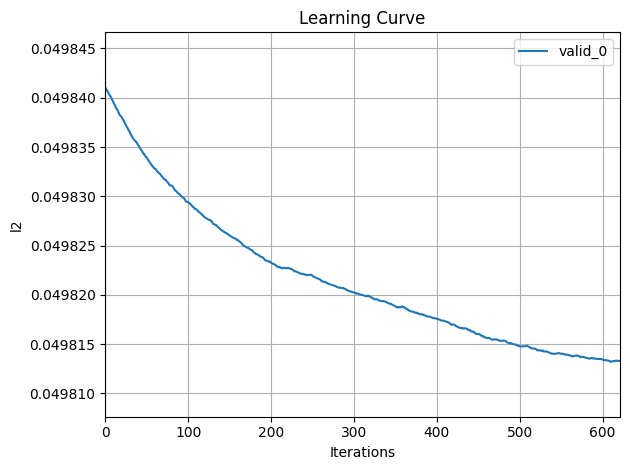

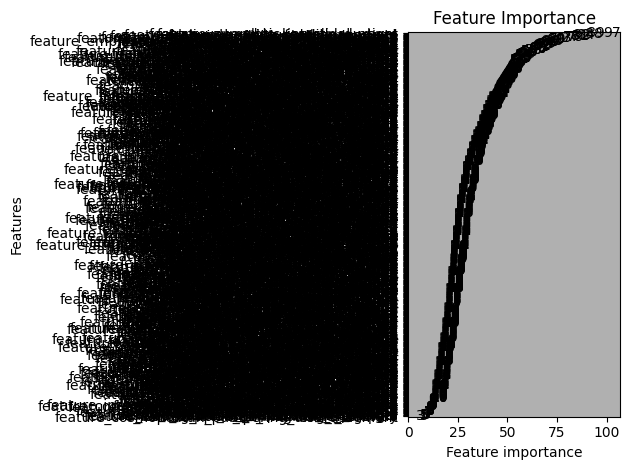

In [15]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

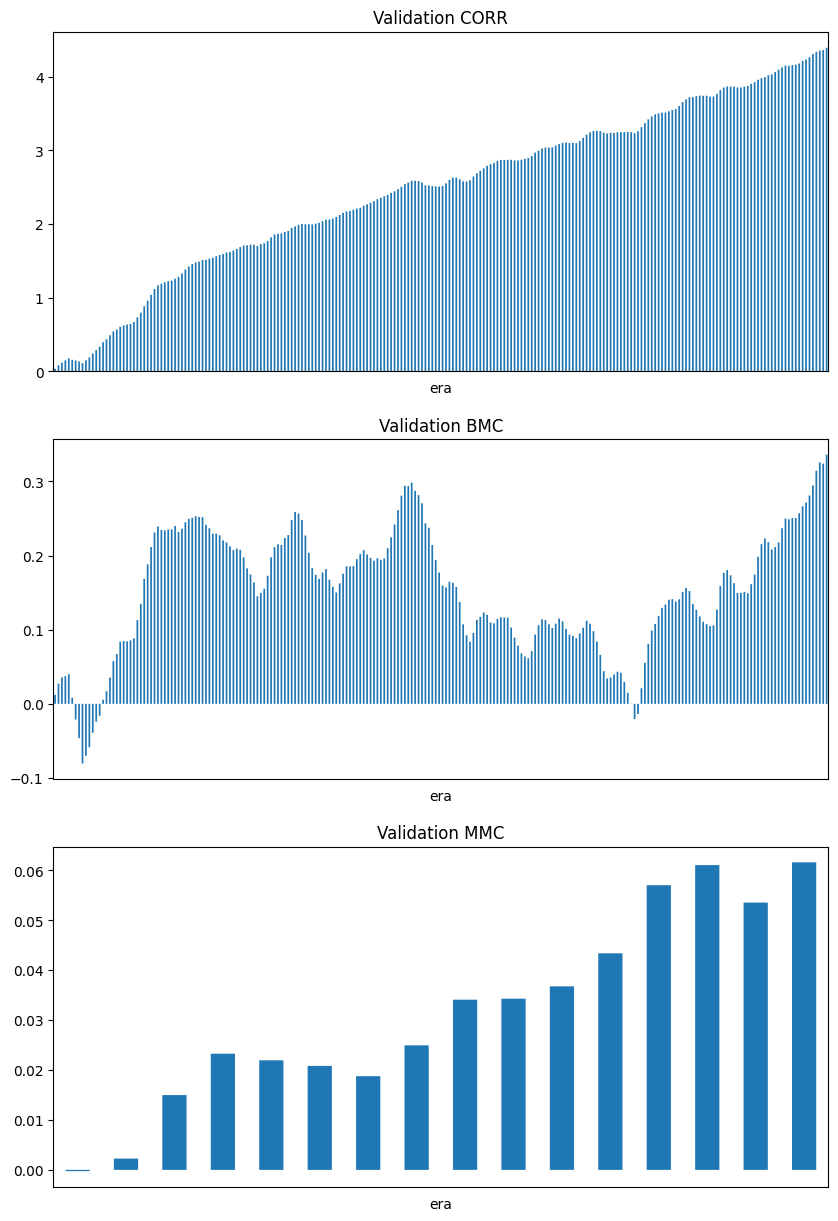

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0   0.019447  0.020297     0.95812           0.079201  0.003851  0.005789   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0   0.665218          0.007505  0.001487  0.012707   0.116998   
 
    bmc_max_drawdown  
 0           0.31895  ,
           pred
 era           
 0923  0.035539
 0924  0.045514
 0925  0.035974
 0926  0.031330
 0927  0.027218
 ...        ...
 1144  0.043792
 1145  0.028750
 1146  0.017882
 1147  0.007819
 1148  0.029947
 
 [226 rows x 1 columns],
           pred
 era           
 0923  0.012135
 0924  0.015105
 0925  0.008514
 0926  0.001526
 0927  0.002595
 ...        ...
 1144  0.013503
 1145  0.019844
 1146  0.011240
 1147 -0.001620
 1148  0.012116
 
 [226 rows x 1 columns],
           pred
 era           
 1133 -0.000255
 1134  0.002513
 1135  0.012726
 1136  0.008288
 1137 -0.001327
 1138 -0.001119
 1139 -0.002062
 1140  0.006182
 1141  0.009144
 1142  0.000201

In [16]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
caluculate_metrics(cfg.dataset_path, valid)
